The goal here is to test `save_csv_dithers` by running it on `minion_1016_sqlite_new_dithers.db` which was created from the MAF afterburner that appended dithered columns to the `minion_10160_sqlite` output.

Running the `lsst` kernel which points to the local sims_maf repo with the updated rotational dither stacker.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from save_csv_dithers import save_csv_dithers

In [2]:
help(save_csv_dithers)

Help on function save_csv_dithers in module save_csv_dithers:

save_csv_dithers(dbs_path, outDir, rot_rand_seed=42, trans_rand_seed=42, print_progress=True, show_diagnostic_plots=False)
    The goal here is to calculate the translational and rotational dithers for
    various cadences and save the output as a csv file.  These dithers are largely
    the same as in DC1/DC2: 
        - Translational dithers:
            - WFD: large random offsets (as large as 1.75 deg) applied after every visit.
            - DD: small random offsets (as large as 7 arcmin) applied after every visit.
            - Else: no dithers, so `fieldRA`, `fieldDec` are returned.
        - Rotational dithers:
            - All surveys (WFD, DD, else): random between -90, 90 degrees applied after
                                           every filter change. (Break from DC2: Some visits
                                           dont get dithered since they are forced outside
                                      

In [3]:
dbs_path= '/global/cscratch1/sd/awan/dbs_old_unzipped'
outDir = '/global/homes/a/awan/LSST/temp_output'

Found files: ['minion_1016_sqlite_new_dithers.db']

Starting: minion_1016_sqlite_new_dithers.db

Setting up for WFD translational dithers + rot dithers.
Querying database Summary with no constraint for columns ['filter', 'fieldDec', 'night', 'rotTelPos', 'fieldRA'].
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Setting up for DD translational dithers.
Querying database Summary with no constraint for columns ['fieldRA', 'fieldDec', 'night'].
Found 2447931 visits
Running:  [0]


/global/homes/a/awan/LSST/lsstRepos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 1.000000 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


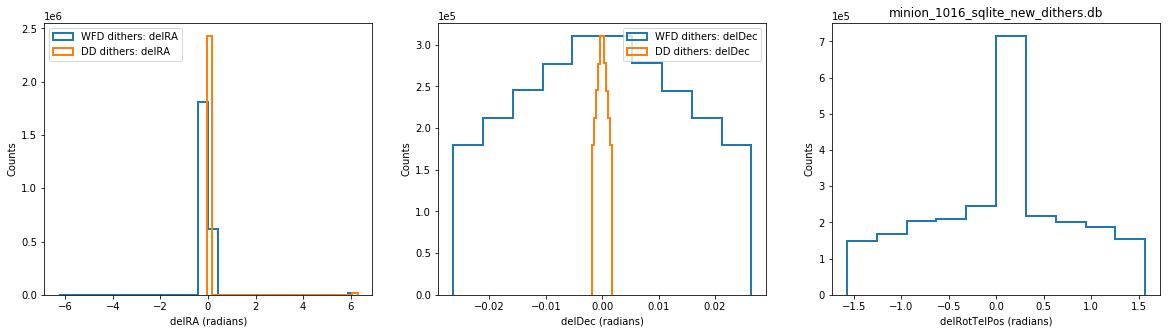

Total visits:  2447931
propTags:  {'WFD': [54], 'DD': [56], 'NES': [55]}
2083433 WFD visits out of total 2447931
111472 DD visits out of total 2447931


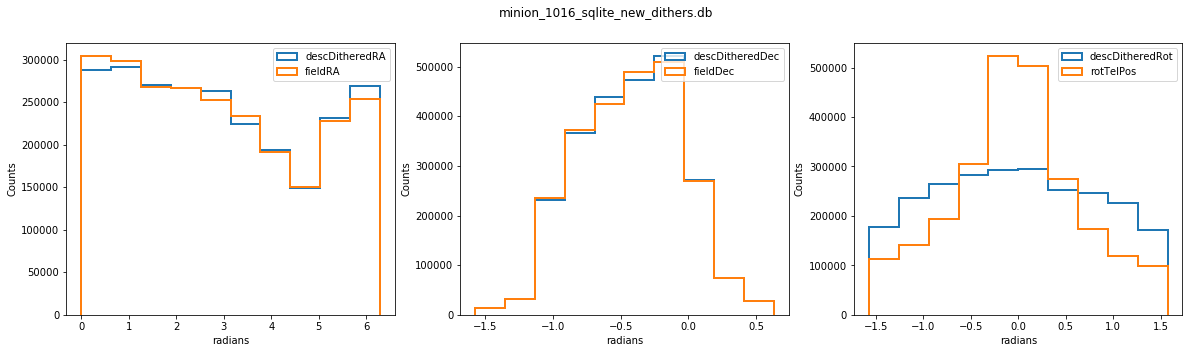


Saved the dithers in descDithers_minion_1016_sqlite_new_dithers.csv
Time taken: 2.45 (min)




In [4]:
save_csv_dithers(dbs_path, outDir, rot_rand_seed=42, trans_rand_seed=42,
                 print_progress=True, show_diagnostic_plots=True)

Okay need to compare saved output result with the columns in the db file.

In [5]:
import pandas as pd
import lsst.sims.maf.db as db

In [6]:
# read in the saved file
saved_cols= pd.read_csv('%s/descDithers_minion_1016_sqlite_new_dithers.csv'%outDir)

In [7]:
opsdb = db.OpsimDatabase('%s/minion_1016_sqlite_new_dithers.db'%(dbs_path)) # connect to the database
        
# specify the column names to get from the db file: V3
colnames = ['propID', 'obsHistID', 'fieldRA', 'fieldDec', 'rotTelPos',
           'randomDitherFieldPerVisitRA', 'randomDitherFieldPerVisitDec',
           'ditheredRotTelPos']

# get the data
simdata = opsdb.fetchMetricData(colnames=colnames, sqlconstraint=None)

In [8]:
saved_cols.keys()

Index(['descDitheredDec', 'descDitheredRA', 'descDitheredRotTelPos',
       'obsHistID'],
      dtype='object')

In [9]:
# connect the keys in the saved output to the ones in the .db file
mapKeys= {'descDitheredDec': 'randomDitherFieldPerVisitDec',
          'descDitheredRA': 'randomDitherFieldPerVisitRA',
          'descDitheredRotTelPos': 'ditheredRotTelPos',
          'obsHistID': 'obsHistID'}

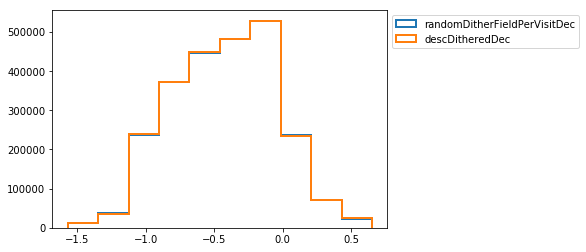

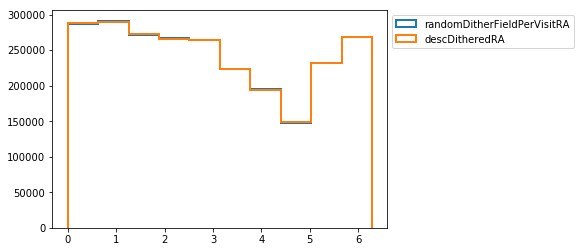

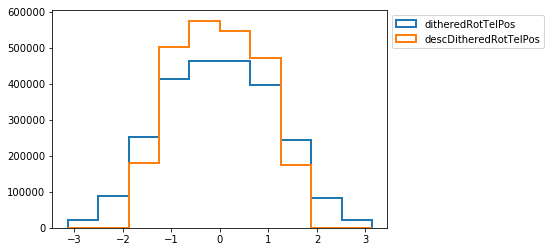

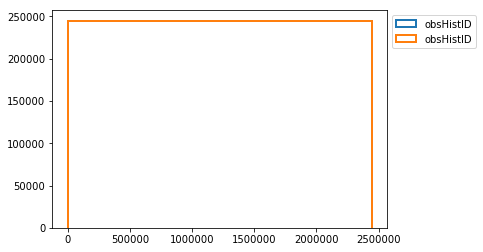

In [10]:
for key in mapKeys:
    _, bins, _ = plt.hist(simdata[mapKeys[key]], label=mapKeys[key], lw=2, histtype='step')
    plt.hist(saved_cols[key], label=key, lw=2, histtype='step', bins=bins)
    
    
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

Okay things look good. Translational dithered match up, and the updated rotational stacker is doing its thing by not allowing descDitehredRotTelPos to go beyond +/-90 degrees.

#### Now check the translational dithers for WFD, DD, etc. specifically.

In [11]:
propTags = {'WFD': [54], 'DD': [56], 'NES': [55]}  # copied from above

Regarding the `propTags`: something is weird since `propTags` only had WFD, DD when I ran the routine on this database before (in Out[15] [here]( https://github.com/LSSTDESC/DC2_visitList/blob/master/DC2visitGen/notebooks/DESC_Dithers.ipynb)) .. so the WFD numbers here are fewer than before.

In [12]:
tot= len(simdata)
print('Total visits: ', tot)

Total visits:  2447931


WFD
2083433 WFD visits out of total 2447931
len(saved inds): 2083433

descDitheredDec: entries match: [False]


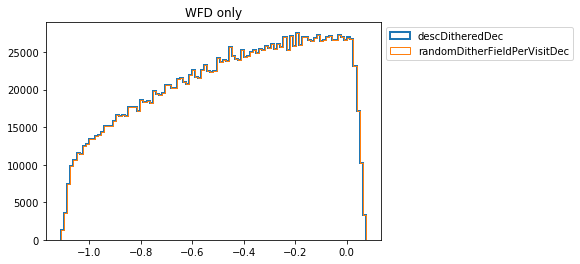

descDitheredRA: entries match: [False]


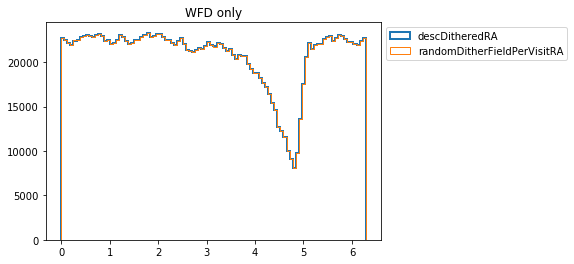

descDitheredRotTelPos: entries match: [False  True]


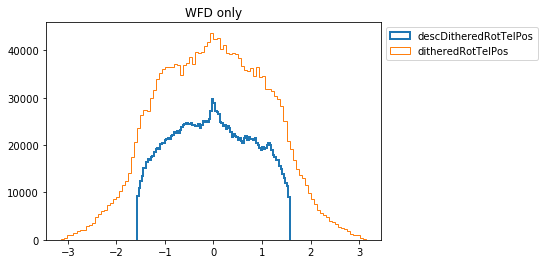

obsHistID: entries match: [ True]


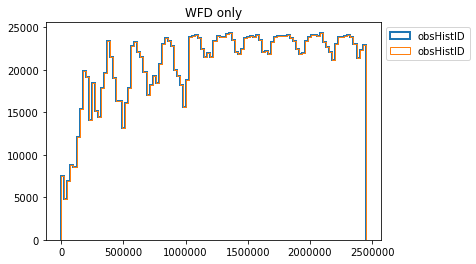

DD
111472 DD visits out of total 2447931
len(saved inds): 111472

descDitheredDec: entries match: [False]


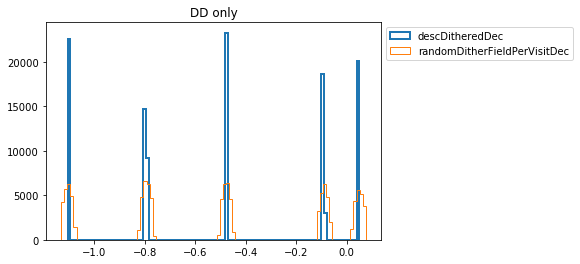

descDitheredRA: entries match: [False]


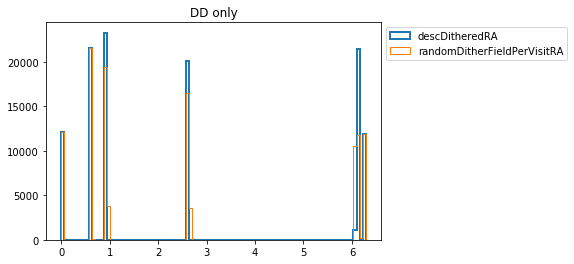

descDitheredRotTelPos: entries match: [False]


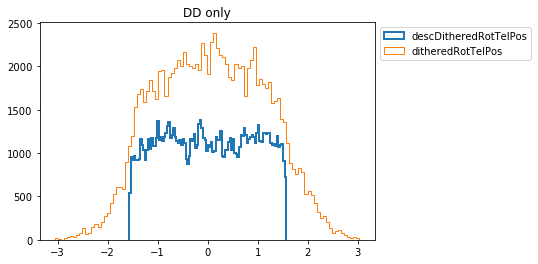

obsHistID: entries match: [ True]


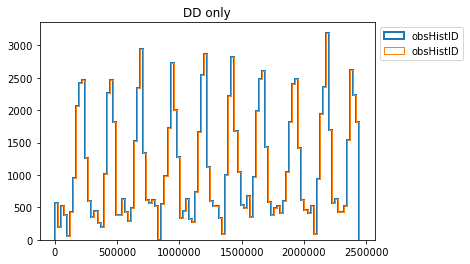

NES
158890 NES visits out of total 2447931
len(saved inds): 158890

descDitheredDec: entries match: [False  True]


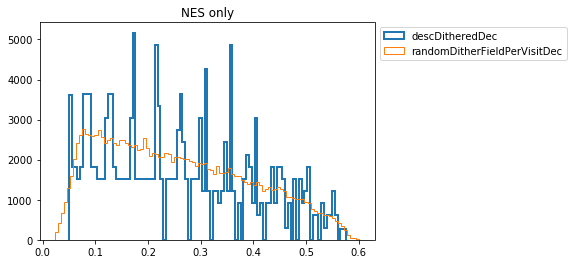

descDitheredRA: entries match: [False  True]


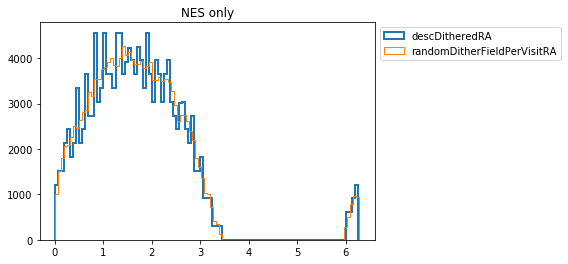

descDitheredRotTelPos: entries match: [False]


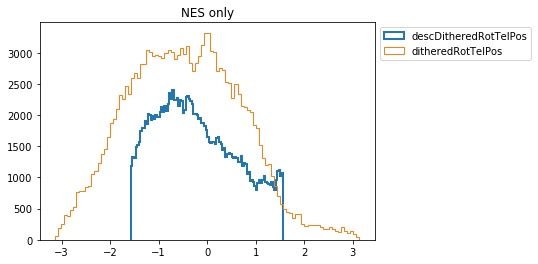

obsHistID: entries match: [ True]


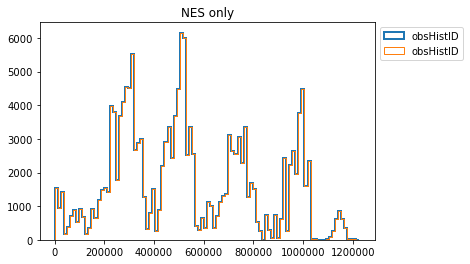

CPU times: user 41min 50s, sys: 14.3 s, total: 42min 4s
Wall time: 42min 2s


In [13]:
%%time
ind_saved = {} # save these since finding them takes time
for propTag in propTags:
    print(propTag)
    
    ind_sim = np.where(simdata['propID']==propTags[propTag])[0]
    print('%s %s visits out of total %s'%(len(ind_sim), propTag, tot))
        
    # find the match between saved data and simdata
    sim_obsIDS = simdata['obsHistID'][ind_sim]

    ind_saved[propTag]= []
    last_ind = None
          
    for ID in sim_obsIDS:
        if last_ind is None:
            last_ind = np.where(saved_cols['obsHistID']==ID)[0][0]
        else:
            last_ind += np.where(saved_cols['obsHistID'][last_ind:]==ID)[0][0]
        ind_saved[propTag].append(last_ind)

    ind_saved[propTag] = np.array(ind_saved[propTag])
    print('len(saved inds): %s\n'%len(ind_saved[propTag]))
          
    # plot stuff
    for key in mapKeys:
        print('%s: entries match: %s'%(key, np.unique(saved_cols[key][ind_saved[propTag]]==simdata[mapKeys[key]][ind_sim])))
        plt.hist(saved_cols[key][ind_saved[propTag]], lw=2, label=key, histtype='step', bins=100)
        plt.hist(simdata[mapKeys[key]][ind_sim], label=mapKeys[key], histtype='step', bins=100)
        plt.legend(bbox_to_anchor=(1,1))
        plt.title('%s only'%propTag)
        plt.show()

##### Okay so descDithered<> is the data that's read from the csv file while dithered<> columns were added by the afterburner. 
- For all three surveys, obsHistIDs match -- good.
- Translational dithers
    - For WFD, descDitheredRA,Dec match ditheredRA,Dec very closely -- good.
    - For DDs, descDitheredDec differs more from ditheredDec than descDitheredRA does from ditheredRA. Not sure how the afterburner handed these visits exactly.
    - For NES, descDitheredDec also differs more from ditheredDec than descDitheredRA does from ditheredRA. Not sure what to make of the exact differences; descDithers are the same as undithered pointings for this survey but its unclear what the afterburner did for these visits.
- Rotational dithers
    - For all surveys, descDitheredRotTelPos is very different from ditheredRotTelPos. The fact that the former ranges from -90 to 90 degrees only is the result of the updated rotational dither stacker.